In [186]:
import pandas as pd
import numpy as np
import re
import cloudscraper
import time
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from urllib.parse import urljoin
from dateutil.parser import parse

from google import genai
from google.genai.types import Schema, Type

In [8]:
def func_estimate_gemini_flash_cost(text, expected_output_tokens=200, model="flash"):
    """
    Estimate Gemini Flash API cost for a given text input.
    Args:
        text (str): Input text.
        expected_output_tokens (int): Approx. output token count (e.g. summary length).
        model (str): "flash" or "flash-lite"
    Returns:
        dict: tokens + cost breakdown.
    """
    # rough estimate: ~4 characters per token (avg English text)
    input_tokens = math.ceil(len(text) / 4)
    output_tokens = expected_output_tokens

    # USD cost per million tokens (input / output)
    pricing = {
        "flash": {"input": 0.075, "output": 0.30},
        "flash-lite": {"input": 0.10, "output": 0.40},
    }

    if model not in pricing:
        raise ValueError("Model must be 'flash' or 'flash-lite'")

    cost_input = (input_tokens / 1_000_000) * pricing[model]["input"]
    cost_output = (output_tokens / 1_000_000) * pricing[model]["output"]
    total = cost_input + cost_output

    return {
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "cost_usd": round(total, 6),
    }

## SCRAPER(s)

### Dawn.com

In [179]:

scraper = cloudscraper.create_scraper()  # handles Cloudflare anti-bot
page_url = "https://www.dawn.com/pakistan"
resp = scraper.get(page_url, timeout=15)
soup = BeautifulSoup(resp.text, 'html.parser')

In [180]:
# Scrape article/story URLs from home page for Pakistan section
all_stories = []
anchors = soup.find_all("a", href=True)
urls = set()
for a in anchors:
    href = a["href"].split("#")[0].split("?")[0]  #  strip fragments and query params
    if not href:
        continue
    # absolute or relative URL to dawn
    if href.startswith("http") and "dawn.com" in href:
        candidate = href
    elif href.startswith("/"):
        candidate = urljoin(page_url, href)
    else:
        continue

    # Filter to likely article/story pages: by year pattern or '/news' or '/pakistan' in path
    if re.search(r"/\d{4}/", candidate) or "/news" in candidate or "/pakistan" in candidate:
        urls.add(candidate)

urls = sorted(urls)
for u in urls:
    all_stories.append(u)


In [181]:
all_stories = [u for u in all_stories if 'news' in u]
all_stories = [u for u in all_stories if 'images.dawn' not in u] #filter out stories by dawn images

In [182]:
story_data_list = []

In [183]:
# Scrape content for each story URL
parsed_urls = set([item['url'] for item in story_data_list])
for story in all_stories:
    if story not in parsed_urls:
        for attempt in range(5):
            try:
                time.sleep(1)
                resp = scraper.get(story, timeout=15)
                soup = BeautifulSoup(resp.text, 'html.parser')
                print(story)
                story_title = soup.title.get_text(strip=True)
                story_content = soup.select_one('div.story__content').get_text(separator='\n', strip=True)
                story_timestamp = soup.select_one('span.timestamp--date').get_text(separator='\n', strip=True)
                story_timestamp = parse(story_timestamp)
                story_byline = soup.select_one('a.story__byline__link').get_text()
                story_data = {
                    'url': story,
                    'title': story_title,
                    'content': story_content,
                    'timestamp': story_timestamp,
                    'byline': story_byline
                }
                story_data_list.append(story_data)
                break  # success, move to next story
            except AttributeError as e:
                if attempt < 4:
                    print(f"AttributeError parsing {story}, retrying ({attempt+1}/5)...")
                    time.sleep(1)
                    continue
                else:
                    print(f"Failed to parse {story} after 5 attempts: {e}")
            except Exception as e:
                # non-AttributeError (network, parser, etc.) — report and skip
                print(f"Error fetching/parsing {story}: {e}")
                break
    else:
        print(f"Skipping already parsed URL: {story}")

https://www.dawn.com/news/1947463/army-brass-warns-india-any-imaginary-new-normal-to-be-met-with-new-normal-of-swift-retributive-response
https://www.dawn.com/news/1948886
https://www.dawn.com/news/1948887
https://www.dawn.com/news/1949486/how-to-fix-blurry-images-and-enhance-photos-with-ai
https://www.dawn.com/news/1949540/why-are-multinationals-exiting-pakistan
https://www.dawn.com/news/1949648/pakistan-sells-first-women-bank-to-uae-firm
https://www.dawn.com/news/1949677/shift-in-kabul-ties-imminent-as-more-terror-hideouts-hit
https://www.dawn.com/news/1949694/punjab-agri-dept-signs-four-mous-with-chinese-firms
https://www.dawn.com/news/1949695/zimbabwe-roped-in-after-afghanistan-pulls-out-of-upcoming-tri-nation-series
https://www.dawn.com/news/1949711/no-space-for-war-in-nuclearised-environment-coas-munir-cautions-india
https://www.dawn.com/news/1949733/pakistan-cricket-board-to-finalise-new-odi-skipper-ahead-of-south-africa-series
https://www.dawn.com/news/1949741/pakistan-fall-to-

In [184]:
story_data_df = pd.DataFrame(story_data_list)
max_minus_5_days = story_data_df.timestamp.max() - pd.Timedelta(days=5)
story_data_df[story_data_df['timestamp'] >= max_minus_5_days] # filter to last 5 days
story_data_df['input_tokens'] = story_data_df['content'].apply(lambda x: func_estimate_gemini_flash_cost(x)['input_tokens'])
story_data_df['token_cost_usd'] = story_data_df['content'].apply(lambda x: func_estimate_gemini_flash_cost(x)['cost_usd'])

In [185]:
story_data_df.to_csv("../data/dawn_news_stories.csv", index=False)
story_data_df.to_pickle("../data/dawn_news_stories.pkl")

## Generate sentiment summary with Gemini Flash

In [132]:
# import google.auth

# creds, project = google.auth.default()
# print("Authenticated as:", creds.service_account_email)
# # print("Project:", project)

In [156]:
PROJECT_ID = "medium-blog-services"
REGION = "us-central1"
client = genai.Client(
    vertexai=True, project=PROJECT_ID, location='us-central1'
)

In [157]:
analyst_prompt = """ You are a political scientist expert in South Asian affairs, with complete understanding of the historical, cultural, and geopolitical context of the region. Your task is to analyze news articles and provide insights on the political implications, key stakeholders, and potential outcomes of the events described.
For each article, your job is to quantify the news along key attributes:

1. Sentiment: Rate the overall sentiment of the article on a scale from -5 (very negative) to +5 (very positive).

2. Political Impact: Assess whether this article indicates an increase or decrease in political stability on a scale from -5 (significantly destabilizing) to +5 (significantly stabilizing).

3. Economic Impact: Evaluate the potential economic impact of the events discussed in the article on a scale from -5 (severely negative) to +5 (highly positive).

4. Climate Impact: Determine the environmental implications of the article's content on a scale from -5 (severely negative) to +5 (highly positive).

5. Social Cohesion: Analyze how the events in the article might affect social cohesion within the region on a scale from -5 (severely divisive) to +5 (highly unifying).

6. International Relations: Examine the potential effects of the article's content on the country's international relations on a scale from -5 (severely damaging) to +5 (highly beneficial).

7. Regional Security: Consider the implications of the article for regional security dynamics on a scale from -5 (significantly destabilizing) to +5 (significantly stabilizing).

Please format your response as a JSON object with the following keys: sentiment, political_stability, economic_impact, climate_impact, social_cohesion, international_relations, regional_security. Each key should map to an integer value within the specified range. Ensure that your analysis is concise and directly addresses each attribute based on the content of the article.

Below is the article to analyze:
Title: {title}
Content: {content}
"""

In [158]:


analyst_schema = Schema(
    type=Type.OBJECT,
    properties={
        "sentiment": Schema(
            type=Type.INTEGER,
            description="Overall sentiment (-5 very negative, +5 very positive)"
        ),
        "political_stability": Schema(
            type=Type.INTEGER,
            description="Political impact (-5 destabilizing, +5 stabilizing)"
        ),
        "economic_impact": Schema(
            type=Type.INTEGER,
            description="Economic impact (-5 severely negative, +5 highly positive)"
        ),
        "climate_impact": Schema(
            type=Type.INTEGER,
            description="Environmental impact (-5 severely negative, +5 highly positive)"
        ),
        "social_cohesion": Schema(
            type=Type.INTEGER,
            description="Effect on social cohesion (-5 divisive, +5 unifying)"
        ),
        "international_relations": Schema(
            type=Type.INTEGER,
            description="Impact on international relations (-5 damaging, +5 beneficial)"
        ),
        "regional_security": Schema(
            type=Type.INTEGER,
            description="Impact on regional security (-5 destabilizing, +5 stabilizing)"
        ),
    },
    required=[
        "sentiment",
        "political_stability",
        "economic_impact",
        "climate_impact",
        "social_cohesion",
        "international_relations",
        "regional_security"
    ]
)

In [171]:
gemini_responses = []
for ind, row in story_data_df.iterrows():
    title = row['title']
    content = row['content']
    prompt = analyst_prompt.format(title=title, content=content)
    time.sleep(1)

    max_attempts = 6
    attempt = 0
    while attempt < max_attempts:
        try:
            response = client.models.generate_content(
                model='gemini-2.5-flash-lite',
                contents=prompt,
                config={
                    'responseMimeType': 'application/json',
                    'responseSchema': analyst_schema,
                    'temperature': 0.2,
                    'seed': 420
                }
            )

            response_json = json.loads(response.text)

            gemini_response = {
                'url': row['url'],
                'sentiment': response_json['sentiment'],
                'political_stability': response_json['political_stability'],
                'economic_impact': response_json['economic_impact'],
                'climate_impact': response_json['climate_impact'],
                'social_cohesion': response_json['social_cohesion'],
                'international_relations': response_json['international_relations'],
                'regional_security': response_json['regional_security'],
                'meta_confidnence': np.exp(response.candidates[0].avg_logprobs),
                'meta_prompt_tokens': response.usage_metadata.prompt_token_count,
                'meta_total_tokens': response.usage_metadata.total_token_count
            }
            print(gemini_response)
            gemini_responses.append(gemini_response)
            break  # success, move to next row

        except KeyboardInterrupt:
            raise
        except Exception as e:
            attempt += 1
            print(f"Client error for index {ind} (attempt {attempt}/{max_attempts}): {e}")
            if attempt >= max_attempts:
                print(f"Max attempts reached for index {ind}, skipping.")
                break
            # Wait 10 seconds and retry the same item
            time.sleep(10)

{'url': 'https://www.dawn.com/news/1947463/army-brass-warns-india-any-imaginary-new-normal-to-be-met-with-new-normal-of-swift-retributive-response', 'sentiment': -3, 'political_stability': -3, 'economic_impact': -2, 'climate_impact': 0, 'social_cohesion': -2, 'international_relations': -1, 'regional_security': -4, 'meta_confidnence': 0.9920797133546219, 'meta_prompt_tokens': 1640, 'meta_total_tokens': 1711}
{'url': 'https://www.dawn.com/news/1948886', 'sentiment': -4, 'political_stability': -1, 'economic_impact': -2, 'climate_impact': -4, 'social_cohesion': -1, 'international_relations': -1, 'regional_security': -1, 'meta_confidnence': 0.9827954611107182, 'meta_prompt_tokens': 1752, 'meta_total_tokens': 1823}
{'url': 'https://www.dawn.com/news/1948887', 'sentiment': -2, 'political_stability': -1, 'economic_impact': -3, 'climate_impact': -4, 'social_cohesion': -1, 'international_relations': -1, 'regional_security': -2, 'meta_confidnence': 0.9710937568666118, 'meta_prompt_tokens': 2667, 

In [ ]:
gemini_responses_df = pd.DataFrame(gemini_responses)
story_data_df = story_data_df.merge(gemini_responses_df, on='url', how='left')\
    .drop_duplicates(subset=['url'])
story_data_df.to_pickle("../data/dawn_news_stories_w_gemini25flashlite.pkl")
story_data_df.to_csv("../data/dawn_news_stories_w_gemini25flashlite.csv",index=False)

## Visualize

In [190]:
story_data_df = pd.read_pickle("../data/../data/dawn_news_stories_w_gemini25flashlite.pkl")

In [198]:
json.loads(story_data_df.head(1).to_json())

{'url': {'0': 'https://www.dawn.com/news/1947463/army-brass-warns-india-any-imaginary-new-normal-to-be-met-with-new-normal-of-swift-retributive-response'},
 'title': {'0': 'Army brass warns India any ‘imaginary new normal’ to be met with ‘new normal of swift retributive response’ - Pakistan - DAWN.COM'},
 'content': {'0': 'The military’s top brass warned India on Wednesday that any “imaginary new normal” its leadership might be entertaining about bilateral dynamics would be met with a “new normal of swift retributive response”.\nThe statement from the army brass, released after the 272nd Corps Commanders’ Conference (CCC) held at General Headquarters (GHQ), comes in the wake of last week’s\nprovocative remarks\nby top Indian civil-military leadership.\nIndian Army Chief General Upendra Dwivedi had warned Pakistan that it must stop state-sponsored terrorism if it wanted to retain its place on the map. He had said that Indian forces would “not show any restraint this time”, potentially h

In [ ]:
# Example: your dataframe
df = story_data_df  # replace with your actual dataframe

# Convert timestamp to datetime
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')

# Select the columns to plot
score_cols = ['sentiment', 'political_stability', 'economic_impact',
              'climate_impact', 'social_cohesion', 'international_relations',
              'regional_security']

# Melt the dataframe to long format
df_long = df.melt(
    id_vars=['date'],
    value_vars=score_cols,
    var_name='score_type',
    value_name='score'
)

df_long.head()


,date,score_type,score
0,2025-10-08,sentiment,-3
1,2025-10-17,sentiment,-4
2,2025-10-15,sentiment,-2
3,2025-10-17,sentiment,2
4,2025-10-19,sentiment,-4


In [245]:
df_long = df_long.groupby(['date','score_type']).score.mean().reset_index()
daily_counts = pd.DataFrame(story_data_df.timestamp.value_counts())
# df_long = df_long.merge(daily_counts, on='date', how='left')

<Figure size 640x480 with 0 Axes>

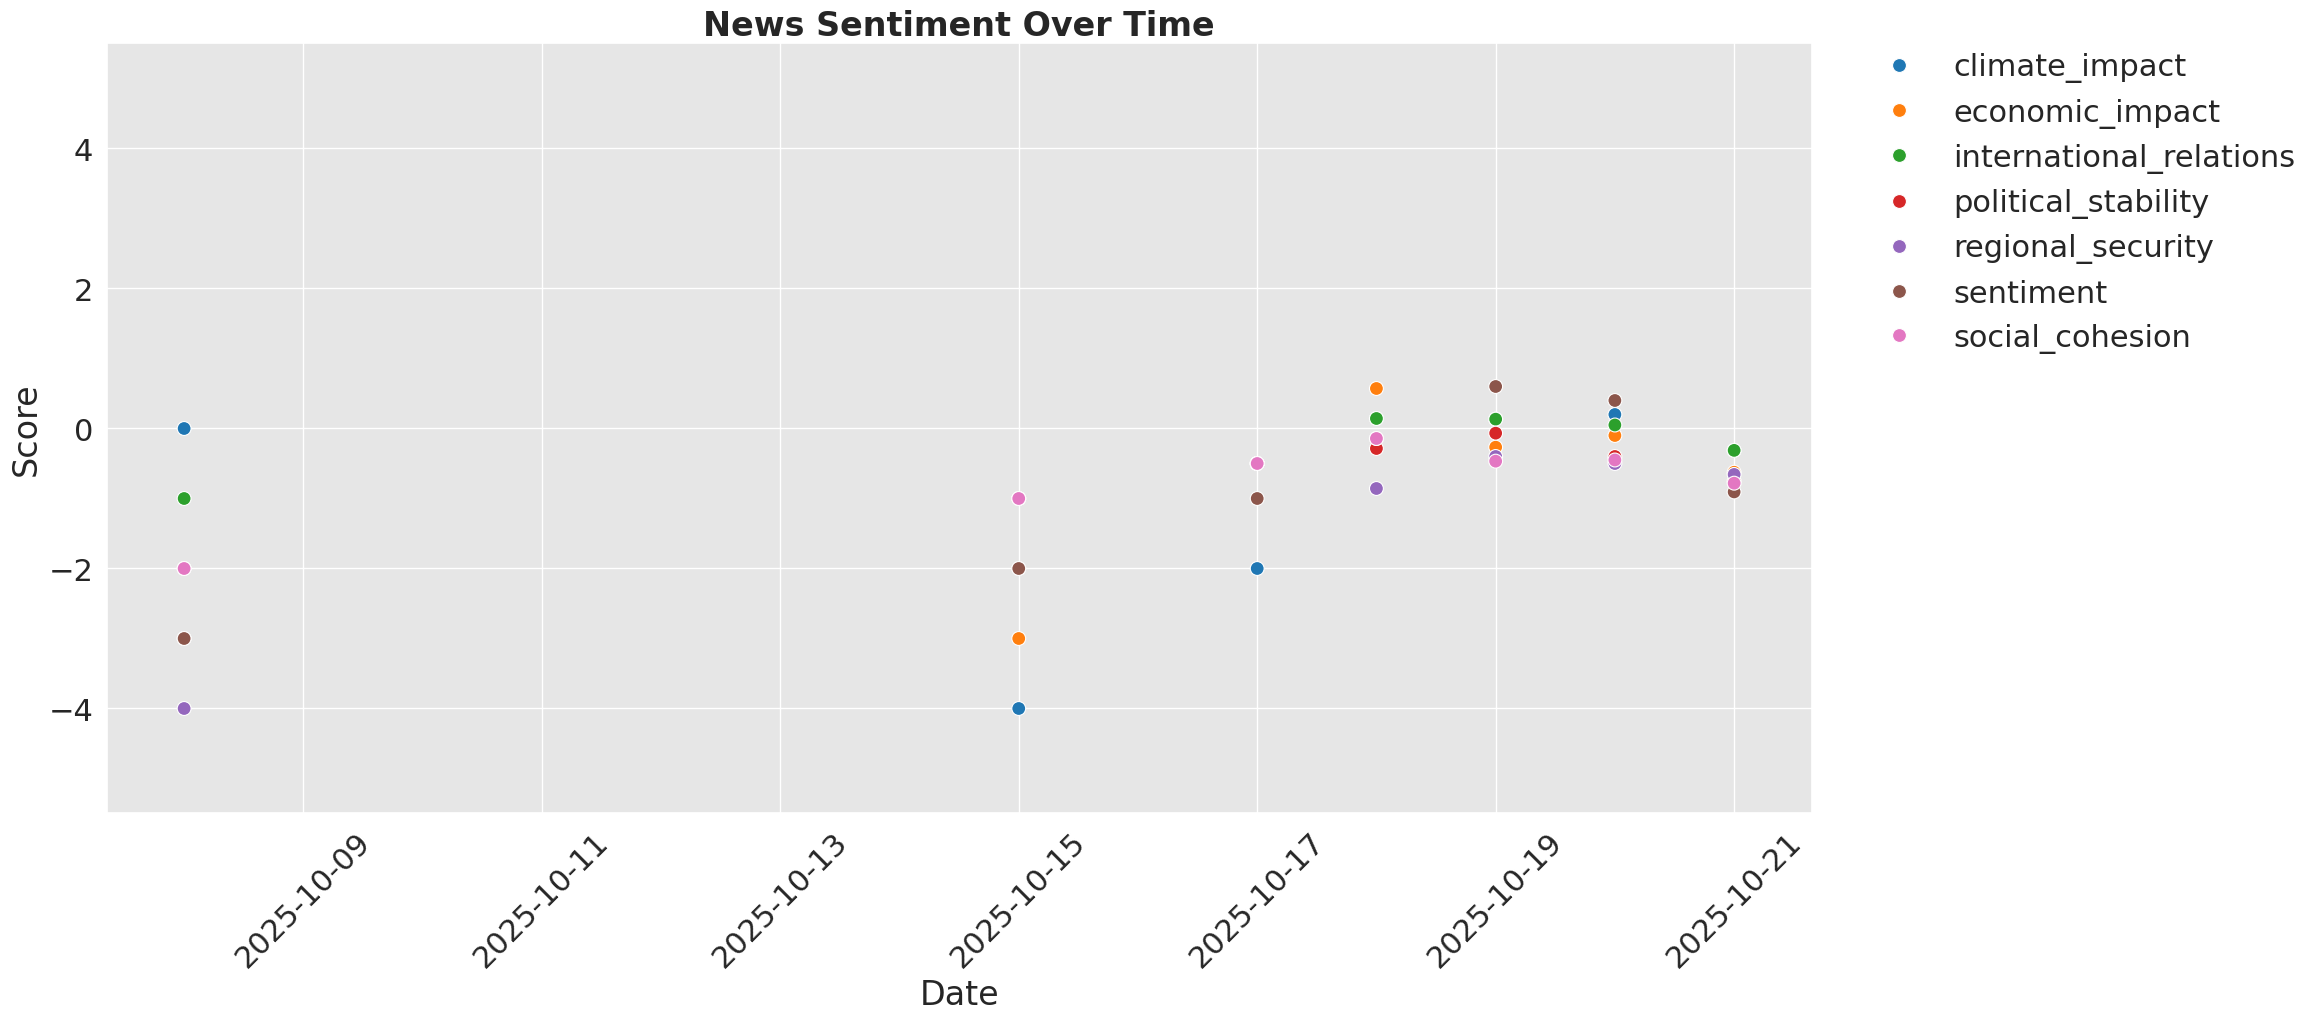

In [ ]:
# Set style
# sns.set(style="whitegrid")
plt.clf()
sns.set_style('darkgrid',{"axes.facecolor": ".9"})
sns.set_style(rc = {'axes.bgcolour': '#c79f52'})
sns.set_context("notebook",font_scale=2,rc={'lines.linewidth':2.1})

plt.figure(figsize=(22, 10))

# Scatter plot
sns.scatterplot(
    data=df_long,
    x='date',
    y='score',
    hue='score_type',  # different color per score type
    palette='tab10',   # choose a color palette
    s=100              # marker size
)

plt.title("News Sentiment Over Time",fontdict={'fontsize':24,'fontweight':'bold'})
plt.ylim(-5.5, 5.5)
plt.xlabel("Date")
plt.ylabel("Average Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.024),frameon=False)
plt.show()
